# Covid Analysis

Track COVID-19 vaccination in the World, answer instantly to your questions:

    Which country is using what vaccine?
    In which country the vaccination programme is more advanced?
    Where are vaccinated more people per day? But in terms of percent from entire population ?


In order to aswer the above questions I am going to use spark as my tool of choice, couple with seaborn to visualize the data. 

In [3]:
import findspark
findspark.init('/home/emanalytics/spark-3.3.1-bin-hadoop3')

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
import pyspark.sql.functions as FN
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas 
import numpy 


In [4]:
spark = SparkSession.builder.config("spark.jars", "/home/emanalytics/Downloads/postgresql-42.5.1.jar") \
    .master("local").appName("Covid Analysis").getOrCreate()

22/12/22 07:39:02 WARN Utils: Your hostname, emanalytics-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/12/22 07:39:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/22 07:39:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Downloaded the data from Kaggle and placed it in the data folder for this project.   called the spark.read.csv() method to load the data into spark.  Since this is a cvs file used the inferSchema and header to build the spark dataframe.  

In [5]:
df = spark.read.csv('data/country_vaccinations.csv', inferSchema=True, header=True)
df.printSchema()
#df.show()

root
 |-- country: string (nullable = true)
 |-- iso_code: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- total_vaccinations: double (nullable = true)
 |-- people_vaccinated: double (nullable = true)
 |-- people_fully_vaccinated: double (nullable = true)
 |-- daily_vaccinations_raw: double (nullable = true)
 |-- daily_vaccinations: double (nullable = true)
 |-- total_vaccinations_per_hundred: double (nullable = true)
 |-- people_vaccinated_per_hundred: double (nullable = true)
 |-- people_fully_vaccinated_per_hundred: double (nullable = true)
 |-- daily_vaccinations_per_million: double (nullable = true)
 |-- vaccines: string (nullable = true)
 |-- source_name: string (nullable = true)
 |-- source_website: string (nullable = true)



Here is the defination for each columns: 

Country- this is the country for which the vaccination information is provided;

Country ISO Code - ISO code for the country;

Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;

Total number of vaccinations - this is the absolute number of total immunizations in the country;

Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;

Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;

Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;

Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;

Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;

Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;

Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;

Number of vaccinations per day - number of daily vaccination for that day and country;

Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;

Vaccines used in the country - total number of vaccines used in the country (up to date);

Source name - source of the information (national authority, international organization, local organization etc.);

Source website - website of the source of information;

Below code tramsforming data field and adding monthyear.  

In [6]:
cleanDF = df.select('country', 
    'iso_code', 
    #FN.concat_ws('-','month','year').alias('monthyear'),
    'date',
    'total_vaccinations',
    'people_vaccinated',
    'people_fully_vaccinated',
    'daily_vaccinations_raw',
    'daily_vaccinations',
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'daily_vaccinations_per_million',
    'vaccines',
    'source_name') \
        .withColumn('monthyear', FN.concat_ws('-', FN.year('date'), FN.month('date'))) \
        .withColumn('year', FN.year('date') )\
        .withColumn('month', FN.month('date') ) \
        .withColumn('day', FN.dayofmonth('date')) \
        .withColumn('quater', FN.quarter('date')) \
        .withColumn('dayoftheweek', FN.date_format('date', 'EEEE')) \
        .withColumn('dayoftheweekindex', FN.when(FN.date_format('date', 'EEEE') == 'Sunday', 1 ) \
                                            .when(FN.date_format('date', 'EEEE') == 'Monday', 2) \
                                            .when(FN.date_format('date', 'EEEE') == 'Tuesday', 3) \
                                            .when(FN.date_format('date', 'EEEE')=='Wednesday', 4) \
                                            .when(FN.date_format('date', 'EEEE')=='Thursday', 5) \
                                            .when(FN.date_format('date', 'EEEE')=='Friday', 6) \
                                            .when(FN.date_format('date', 'EEEE')=='Saturday', 7)) \
        .withColumn('percent', FN.col('people_fully_vaccinated') / FN.col('total_vaccinations')).fillna(0).dropDuplicates().sort(FN.col('date'))

In [7]:
print()

In [8]:
countries = cleanDF.toPandas()
#countries = countries.sort_values(by='date')
countries.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,...,vaccines,source_name,monthyear,year,month,day,quater,dayoftheweek,dayoftheweekindex,percent
0,Norway,NOR,2020-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"Moderna, Pfizer/BioNTech",Norwegian Institute of Public Health,2020-12,2020,12,2,4,Wednesday,4,0.0
1,Norway,NOR,2020-12-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"Moderna, Pfizer/BioNTech",Norwegian Institute of Public Health,2020-12,2020,12,3,4,Thursday,5,0.0
2,Norway,NOR,2020-12-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"Moderna, Pfizer/BioNTech",Norwegian Institute of Public Health,2020-12,2020,12,4,4,Friday,6,0.0
3,Latvia,LVA,2020-12-04,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"Johnson&Johnson, Moderna, Novavax, Pfizer/BioN...",National Health Service,2020-12,2020,12,4,4,Friday,6,0.0
4,Latvia,LVA,2020-12-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"Johnson&Johnson, Moderna, Novavax, Pfizer/BioN...",National Health Service,2020-12,2020,12,5,4,Saturday,7,0.0


The below graph depicts all countries and how total vaccinations trended since 2020. This is important to see how well vaccinations were distributed in the world.  

Text(0.5, 1.0, 'WORLD TOTAL VAX')

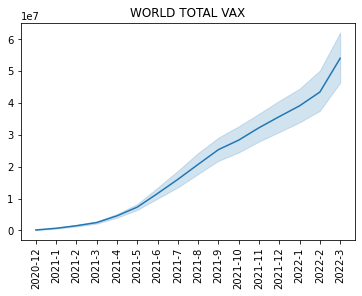

In [9]:
x=countries['monthyear'].values.tolist()
y=countries['total_vaccinations'].values.tolist()
g = sns.lineplot(x=x, y=y)
g.tick_params(axis='x', rotation=90)
g.set_title('WORLD TOTAL VAX')

For the daily vaccinations it does have some peeks and valleys and a downward trend at the most recent months.   Futher investation is required to check why the daily world vaccines are declining.  This can be correlated with how many people have been fully vaccinated. 

Text(0.5, 1.0, 'WORLD TOTAL DAILY VAX')

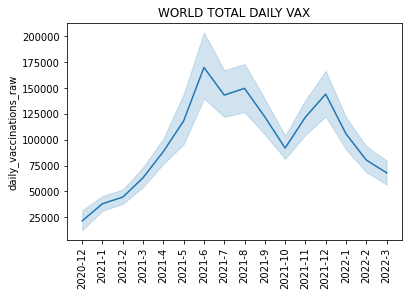

In [10]:
x=countries['monthyear'].values.tolist()
y=countries['daily_vaccinations_raw']
g = sns.lineplot(x=x, y=y)
g.tick_params(axis='x', rotation=90)
g.set_title('WORLD TOTAL DAILY VAX')

As I thought the daily vaccinations declines are due to more poeple being fully vaccinated.    

Text(0.5, 1.0, 'WORLD TOTAL FULLY VAX')

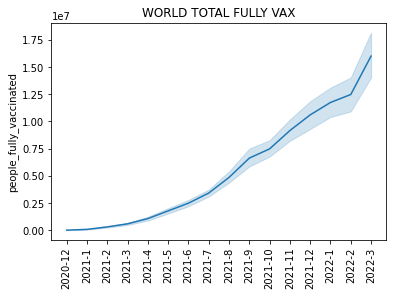

In [22]:
x=countries['monthyear'].values.tolist()
y=countries['people_fully_vaccinated']
g = sns.lineplot(x=x, y=y)
g.tick_params(axis='x', rotation=90)
g.set_title('WORLD TOTAL FULLY VAX')

Text(0.5, 1.0, 'Avg Vaccination by day of the week')

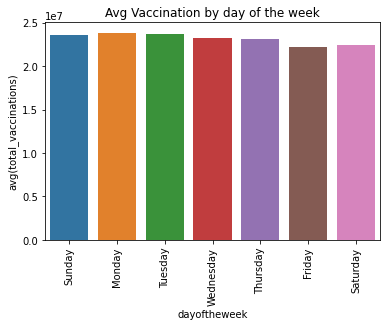

In [12]:
week = cleanDF.groupby('dayoftheweekindex','dayoftheweek').agg({'total_vaccinations': 'mean'}).sort('dayoftheweekindex').toPandas()
week.head()
g = sns.barplot(data=week, x=week['dayoftheweek'], y=week['avg(total_vaccinations)'])
g.tick_params(axis='x', rotation=90)
g.set_title('Avg Vaccination by day of the week')

In [13]:
cleanDF.createOrReplaceTempView('cleanDF')

In [14]:
top15Country = spark.sql("""
    select country
        , iso_code
        , sum(total_vaccinations) as total_vaccinations
        , sum(people_vaccinated) as people_vaccinated 
    from cleanDF
    group by 1,2
    order by total_vaccinations desc 
    limit 15



""").toPandas()

Text(0.5, 1.0, 'Top 15 Countries Total Vaccinations')

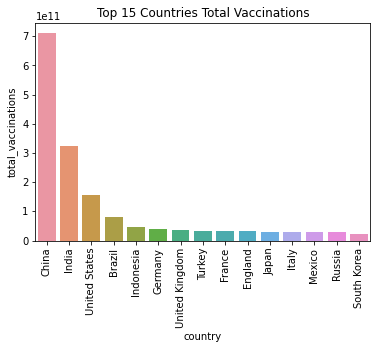

In [15]:
g = sns.barplot(data=top15Country, x='country', y='total_vaccinations', errwidth=0)
g.tick_params(axis='x', rotation=90)
g.set_title('Top 15 Countries Total Vaccinations')

In [16]:
top3countries = spark.sql("""
    select * 
    from cleanDF 
    where country in ('China', 'India', 'United States', 'Brazil', 'Indonesia', 'Germany')

""").toPandas()

Text(0.5, 1.0, 'Top 6 Country Daily Vax')

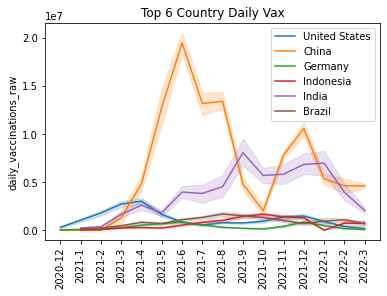

In [17]:
x=top3countries['monthyear'].values.tolist()
y=top3countries['daily_vaccinations_raw']
h=top3countries['country'].values.tolist()
g = sns.lineplot(x=x, y=y, hue=h)
g.tick_params(axis='x', rotation=90)
g.set_title('Top 6 Country Daily Vax')

Text(0.5, 1.0, 'Top 6 Country Total Vax')

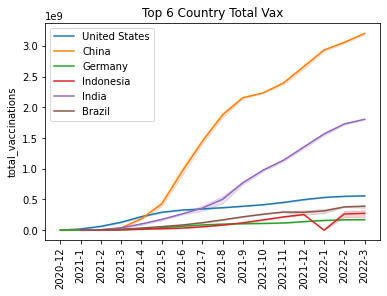

In [18]:
x=top3countries['monthyear'].values.tolist()
y=top3countries['total_vaccinations']
h=top3countries['country'].values.tolist()
g = sns.lineplot(x=x, y=y, hue=h)
g.tick_params(axis='x', rotation=90)
g.set_title('Top 6 Country Total Vax')

Text(0.5, 1.0, 'Top 6 Country Fully Vax')

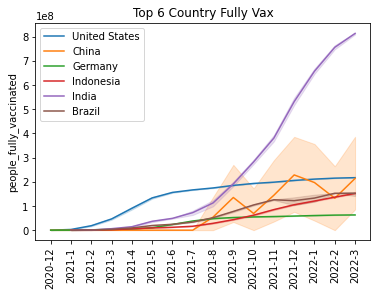

In [19]:
x=top3countries['monthyear'].values.tolist()
y=top3countries['people_fully_vaccinated']
h=top3countries['country'].values.tolist()
g = sns.lineplot(x=x, y=y, hue=h)
g.tick_params(axis='x', rotation=90)
g.set_title('Top 6 Country Fully Vax')

In [20]:
top6countries = spark.sql("""
    select *, (people_fully_vaccinated / total_vaccinations) * 100 as percent 
    from cleanDF 
    where country in ('China', 'India', 'United States', 'Brazil', 'Indonesia', 'Germany')

""").toPandas()

In [21]:
x=top6countries['monthyear'].values.tolist()
y=top6countries['percent']
h=top6countries['country'].values.tolist()
g = sns.lineplot(x=x, y=y, hue=h)
g.tick_params(axis='x', rotation=90)
g.set_title('Top 6 Country Fully Vax')

ValueError: Data must be 1-dimensional

In [ ]:
forScatter = spark.sql("""
    select country
        , people_fully_vaccinated 
        , people_vaccinated
    from cleanDF 
    where country in ('China', 'India', 'United States', 'Brazil', 'Indonesia', 'Germany')
""").toPandas()

In [ ]:
forScatter.head()

,country,people_fully_vaccinated,people_vaccinated
0,United States,5897.0,25125.0
1,United States,6017.0,29543.0
2,United States,6281.0,76984.0
3,China,0.0,0.0
4,United States,6757.0,231496.0


<AxesSubplot: xlabel='people_fully_vaccinated', ylabel='people_vaccinated'>

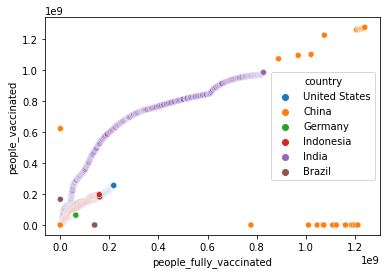

22/12/22 06:53:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 43794330 ms exceeds timeout 120000 ms
22/12/22 06:53:47 WARN SparkContext: Killing executors is not supported by current scheduler.


In [ ]:
sns.scatterplot( x=forScatter['people_fully_vaccinated'], y=forScatter['people_vaccinated'], hue=forScatter['country'])

Aggregate the data by country, iso_code, monthyear, vaccines, source_name using total_vaccinations, people_vacinated to aggregate.    

The vaccines column currently stored as a string per country.  There i used the explode function to split vaccines into individual rows. Decided to create a vaccine dataframe to count how many country used different vaccines.  

In [ ]:
vaccines = cleanDF.select('country', 
                    'iso_code', 
                    FN.explode(FN.split('vaccines', ',')).alias('vaccines'),
                    ).withColumn('vaccines',FN.trim('vaccines')) 
                    
                     
vaccines.createOrReplaceTempView('vaccines')

In [ ]:
spark.sql("""
    select count(*) 
    from vaccines 


""").show()

+--------+
|count(1)|
+--------+
|  310054|
+--------+



I have decided to use the spark sql api to write queries on the spark dataframes I have created.  The reason to use the spark sql api is because because is faster for me to use the sql api then using the dataframe api commands.  

In [ ]:
pdDF.createOrReplaceTempView('pdDF')
vaccines.createOrReplaceTempView('vaccines')

In [ ]:
top25Country = spark.sql("""
    select distinct country
        , iso_code
        , sum(distinct total_vaccinations) as total_vaccinations
        , sum(distinct total_vaccinated) as total_vaccinated 
    from pdDF
    group by 1,2
    order by total_vaccinations desc
    limit 15


""").toPandas()

In [ ]:
pandas.set_option('display.float_format', lambda x: '%.5f' % x)
top25Country.round(0)

,country,iso_code,total_vaccinations,total_vaccinated
0,China,CHN,709452663700.00000,21606369000.00000
1,India,IND,323440305798.00000,205819738338.00000
2,United States,USA,155013867208.00000,80025415381.00000
3,Brazil,BRA,79067174395.00000,43447732662.00000
4,Indonesia,IDN,45214622016.00000,34926315843.00000
5,Germany,DEU,38982830332.00000,18851798732.00000
6,United Kingdom,GBR,36851641768.00000,18238350750.00000
7,Turkey,TUR,33923100933.00000,16076281743.00000
8,France,FRA,32177039372.00000,15843577693.00000
9,England,OWID_ENG,31037114023.00000,15364620469.00000


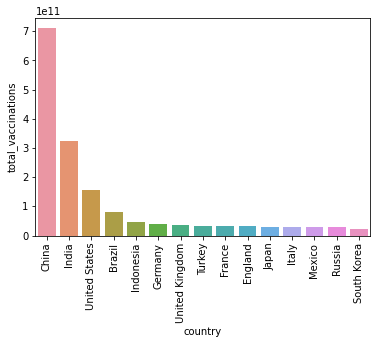

In [ ]:
g = sns.barplot(data=top25Country, x='country', y='total_vaccinations')
g.tick_params(axis='x', rotation=90)

Using the spark.sql api queried the vaccines dataframe using common sql syntax and pulled information on vaccines and how many countries are using a specific vaccine.  From the resultset, OxFord/AtraZenaca is widely popular world wide follow by the Pfizer/BioNtech vaccine.   

In [ ]:
vax = spark.sql(

    """
    select vaccines, count(*) countryCount
    from (
        select distinct  *
        from vaccines
    ) t 
    group by 1 
    order by count(*) desc
    limit 15 
    """
).toPandas()

In [ ]:
vax.head()

,vaccines,countryCount
0,Oxford/AstraZeneca,183
1,Pfizer/BioNTech,158
2,Moderna,90
3,Sinopharm/Beijing,90
4,Johnson&Johnson,89


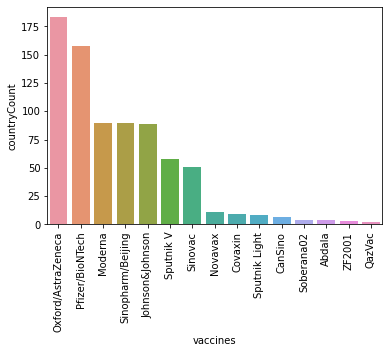

In [ ]:
g = sns.barplot(data=vax, x='vaccines', y='countryCount')
g.tick_params(axis='x', rotation=90)